In [1]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl

In [2]:
# Setup ResNet model
resnet = models.resnet18(pretrained=True)
resnet.eval()
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

/home/alex/miniconda3/envs/petnica/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/miniconda3/envs/petnica/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/alex/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 37.4MB/s]


In [5]:
# Transform pipeline
"""
transform = transforms.Compose([
    transforms.CenterCrop((100,100)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
"""
transform = transforms.Compose([
    transforms.CenterCrop((128,128)),
    transforms.ToTensor()
])

In [6]:
def extract_features_from_directory(img_dir, output_file='features.npy'):
    features_list = []
    filenames = []
    
    for fname in tqdm(os.listdir(img_dir)):
        if not fname.lower().endswith('.jpg'):
            continue
        try:
            img_path = os.path.join(img_dir, fname)
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0)

            with torch.no_grad():
                features = feature_extractor(img_tensor)
                features = features.view(features.size(0), -1).squeeze(0).numpy()
            
            features_list.append(features)
            filenames.append(fname)
        
        except Exception as e:
            print(f"Failed to process {fname}: {e}")

    features_array = np.stack(features_list)
    np.save(output_file, features_array)
    return filenames, features_array

# Example usage
# filenames, features = extract_features_from_directory('path_to_your_images')

In [8]:
dirs = {}
dirs['source_images'] = '/mnt/Data/Work/Sources/Petnica/galzoo/small_sample'
#dirs['source_images'] = '/home/alex/Data/Work/Sources/galaxy-zoo-the-galaxy-challenge/images_training_rev1'

In [9]:
filenames, features = extract_features_from_directory(dirs['source_images'],output_file='resnet_features_galaxyzoo.npy')

100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 80.94it/s]


## Full images

In [9]:
features_all = np.load('features.npy')

In [24]:
idx = np.random.choice(features_all.shape[0], 2000, replace=False)
filenames = np.array(os.listdir(dirs['source_images']))[idx]
features = features_all[idx, :]

#### Visualize features

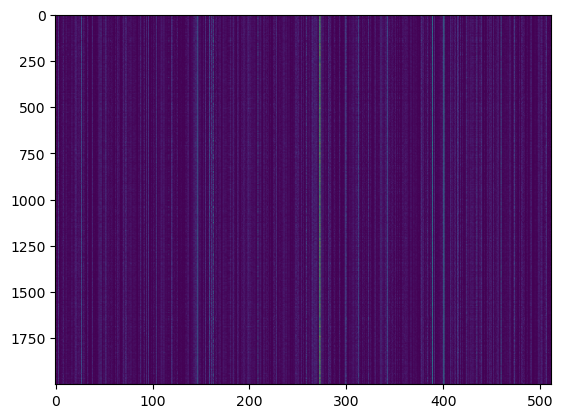

In [25]:
plt.imshow(features,aspect='auto')

#### HDBScan clustering

In [44]:
hdb = skl.cluster.HDBSCAN(min_cluster_size=6)
hdb.fit(features)

HDBSCAN(min_cluster_size=6)

In [45]:
hdb.labels_

array([-1, -1, -1, ..., -1, -1, -1], shape=(2000,))

In [36]:
sum(hdb.labels_==3)

np.int64(668)

In [38]:
hdb_features = features[hdb.labels_==3]
hdb_filenames = filenames[hdb.labels_==3]

#### tSNE embeddings

In [39]:
X_embedded = skl.manifold.TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(hdb_features)

In [40]:
X_embedded.shape

(668, 2)

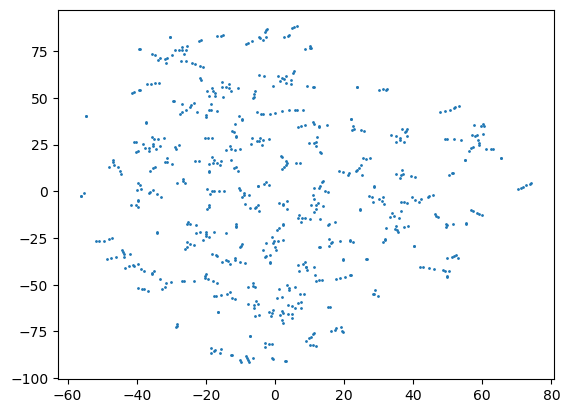

In [41]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=1)

#### Visualize with Bokeh

In [23]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [24]:
output_notebook()

Loading BokehJS ...

In [25]:
from bokeh.models import HoverTool

In [26]:
hover = HoverTool(tooltips=[('@x','@y')])
p = figure(width=400, height=400,tools=[hover])

# add a circle renderer with a size, color, and alpha
p.scatter(X_embedded[:,0],X_embedded[:,1], size=20, color="navy", alpha=0.5)


GlyphRenderer(id='p1029', ...)

In [27]:
show(p)

### Plot galaxies

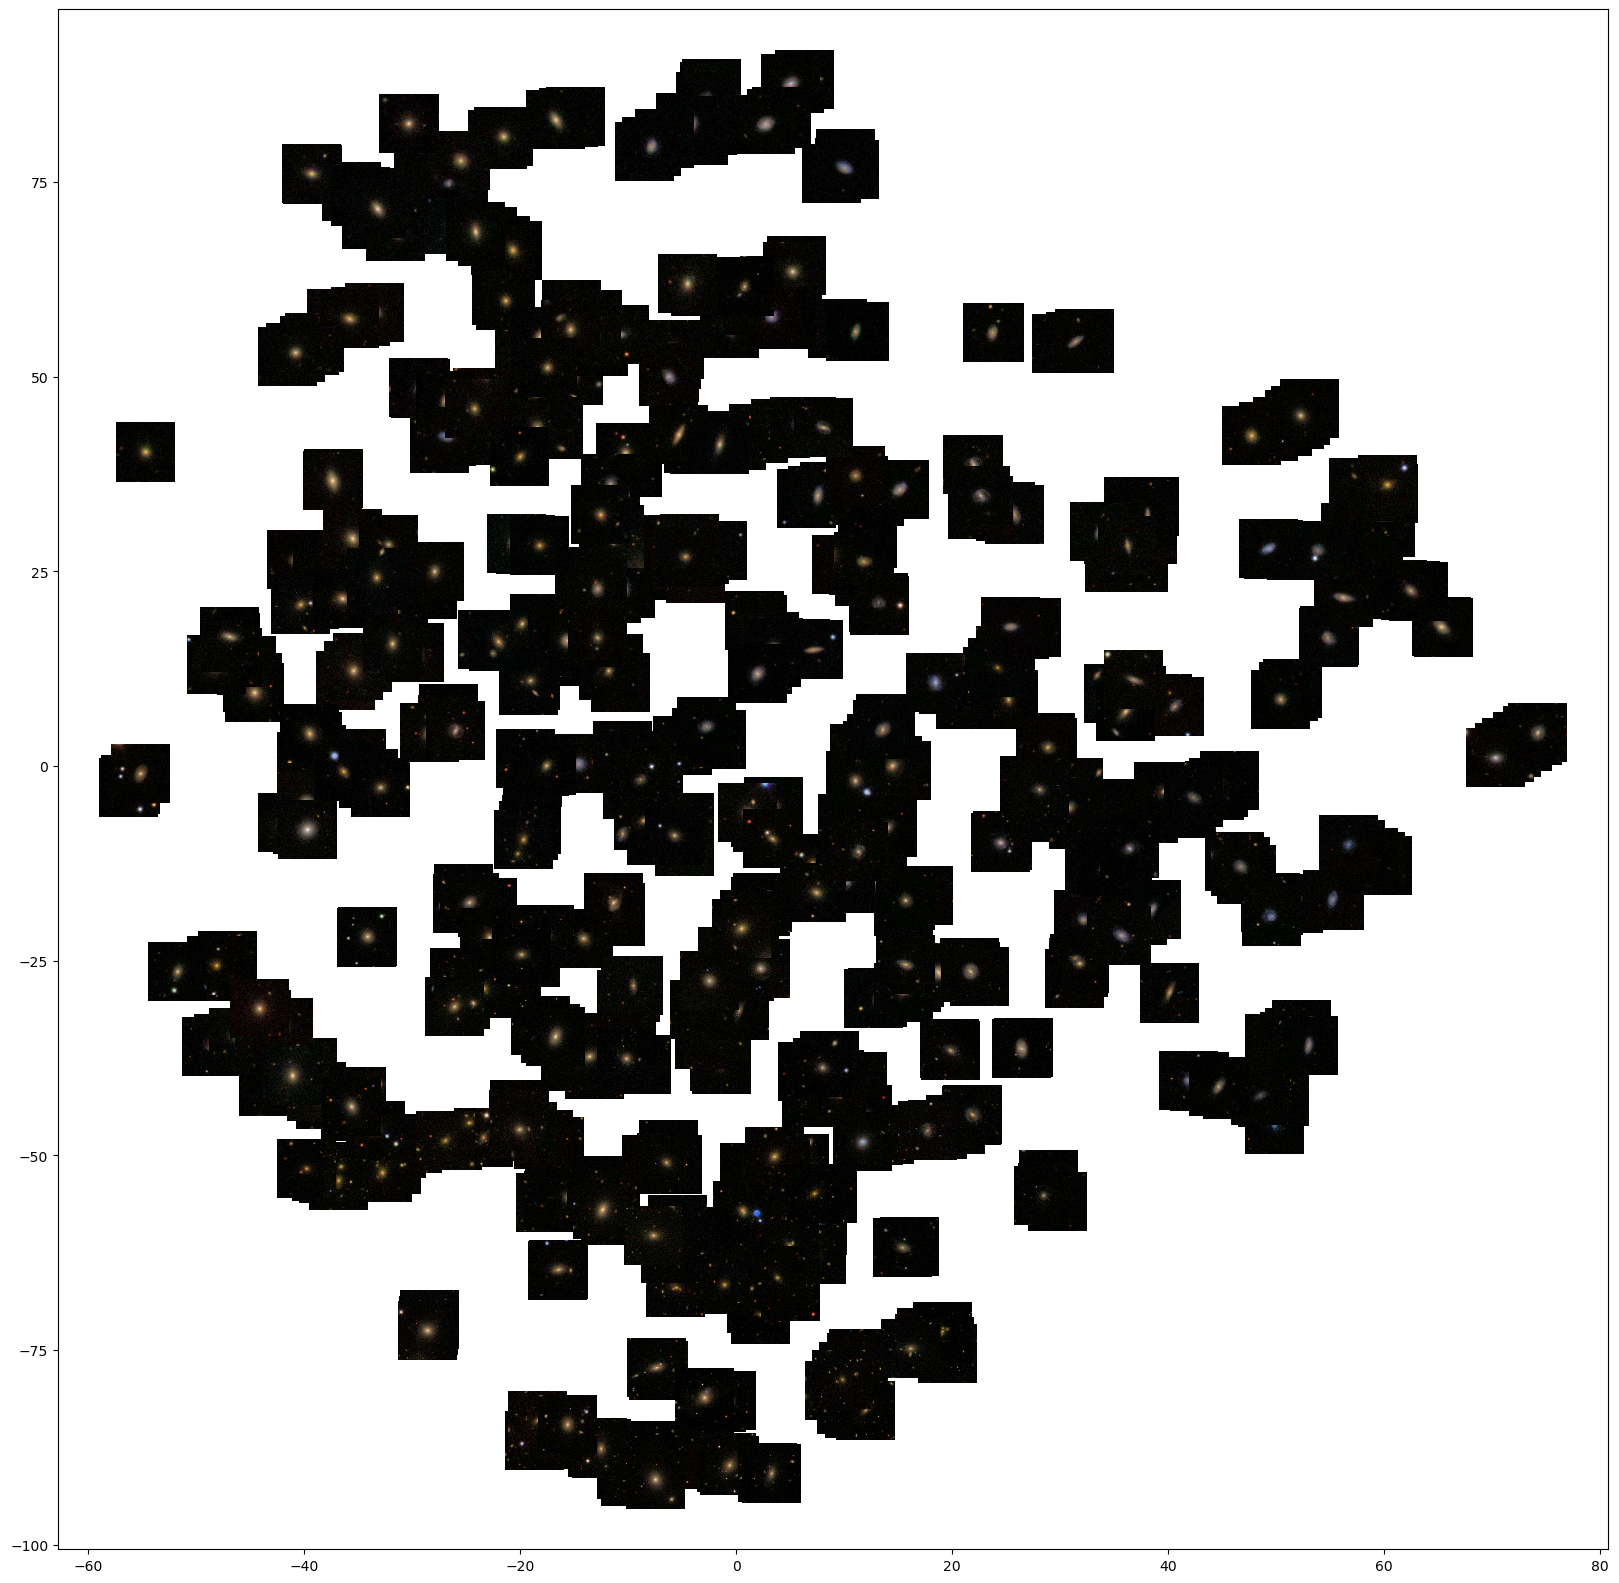

In [43]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def main():
    x = X_embedded[:,0]
    y = X_embedded[:,1]
    fig, ax = plt.subplots(figsize=(20,20))
    imscatter(x, y, hdb_filenames, zoom=0.1, ax=ax)
    #ax.plot(x, y)
    plt.show()

def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    artists = []
    for x0, y0, imgpath in zip(x, y,images):
        image = plt.imread(os.path.join(dirs['source_images'],imgpath))
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main()

### Using tabular data

In [48]:
classes = pd.read_csv('/home/alex/Data/Work/Sources/galaxy-zoo-the-galaxy-challenge/training_solutions_rev1.csv')

In [49]:
classes

GalaxyID  Class1.1  Class1.2  Class1.3  Class2.1  Class2.2  Class3.1  \
0        100008  0.383147  0.616853  0.000000  0.000000  0.616853  0.038452   
1        100023  0.327001  0.663777  0.009222  0.031178  0.632599  0.467370   
2        100053  0.765717  0.177352  0.056931  0.000000  0.177352  0.000000   
3        100078  0.693377  0.238564  0.068059  0.000000  0.238564  0.109493   
4        100090  0.933839  0.000000  0.066161  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
61573    999948  0.510379  0.489621  0.000000  0.059207  0.430414  0.000000   
61574    999950  0.901216  0.098784  0.000000  0.000000  0.098784  0.000000   
61575    999958  0.202841  0.777376  0.019783  0.116962  0.660414  0.067245   
61576    999964  0.091000  0.909000  0.000000  0.045450  0.863550  0.022452   
61577    999967  0.767000  0.140000  0.093000  0.000000  0.140000  0.000000   

       Class3.2  Class4.1  Class4.2  ...  Class9.3  Class10.1  Class10.2  \
0      0.578401  0.418398  0.198455  ...  0.000000   0.279952   0.138445   
1      0.165229  0.591328  0.041271  ...  0.018764   0.000000   0.131378   
2      0.177352  0.000000  0.177352  ...  0.000000   0.000000   0.000000   
3      0.129071  0.189098  0.049466  ...  0.000000   0.094549   0.000000   
4      0.000000  0.000000  0.000000  ...  0.000000   0.000000   0.000000   
...         ...       ...       ...  ...       ...        ...        ...   
61573  0.430414  0.226257  0.204157  ...  0.000000   0.226257   0.000000   
61574  0.098784  0.000000  0.098784  ...  0.000000   0.000000   0.000000   
61575  0.593168  0.140022  0.520391  ...  0.000000   0.000000   0.090673   
61576  0.841098  0.795330  0.068220  ...  0.000000   0.068398   0.318132   
61577  0.140000  0.023380  0.116620  ...  0.000000   0.023380   0.000000   

       Class10.3  Class11.1  Class11.2  Class11.3  Class11.4  Class11.5  \
0       0.000000   0.000000   0.092886   0.000000   0.000000        0.0   
1       0.459950   0.000000   0.591328   0.000000   0.000000        0.0   
2       0.000000   0.000000   0.000000   0.000000   0.000000        0.0   
3       0.094549   0.189098   0.000000   0.000000   0.000000        0.0   
4       0.000000   0.000000   0.000000   0.000000   0.000000        0.0   
...          ...        ...        ...        ...        ...        ...   
61573   0.000000   0.000000   0.000000   0.000000   0.000000        0.0   
61574   0.000000   0.000000   0.000000   0.000000   0.000000        0.0   
61575   0.049349   0.000000   0.067726   0.000000   0.000000        0.0   
61576   0.408799   0.227464   0.408799   0.090668   0.023065        0.0   
61577   0.000000   0.000000   0.000000   0.000000   0.000000        0.0   

       Class11.6  
0       0.325512  
1       0.000000  
2       0.000000  
3       0.000000  
4       0.000000  
...          ...  
61573   0.226257  
61574   0.000000  
61575   0.072296  
61576   0.045334  
61577   0.023380  

[61578 rows x 38 columns]

In [50]:
features_expert = np.array(classes[[c for c in classes.columns if 'Class' in c]])

In [53]:
idx = np.random.choice(features_expert.shape[0], 2000, replace=False)
filenames = np.array(os.listdir(dirs['source_images']))[idx]
features = features_expert[idx, :]

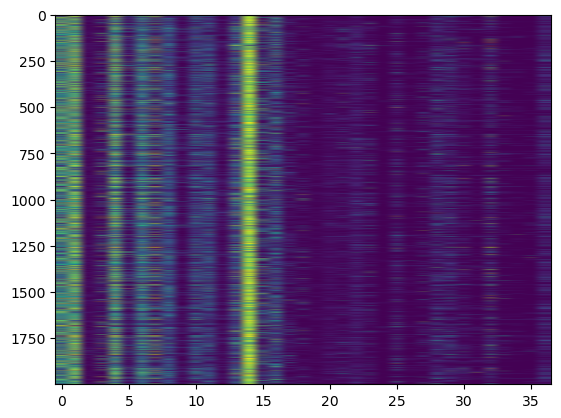

In [60]:
plt.imshow(features,aspect='auto')

In [54]:
hdb = skl.cluster.HDBSCAN(min_cluster_size=6)
hdb.fit(features)

HDBSCAN(min_cluster_size=6)

In [58]:
sum(hdb.labels_==3)

np.int64(545)

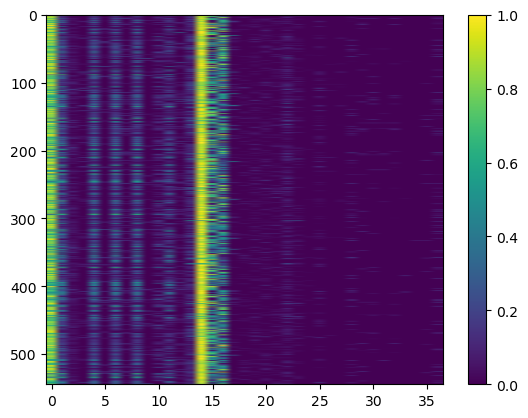

In [66]:
im = plt.imshow(features[hdb.labels_==3],aspect='auto')
plt.colorbar(im)

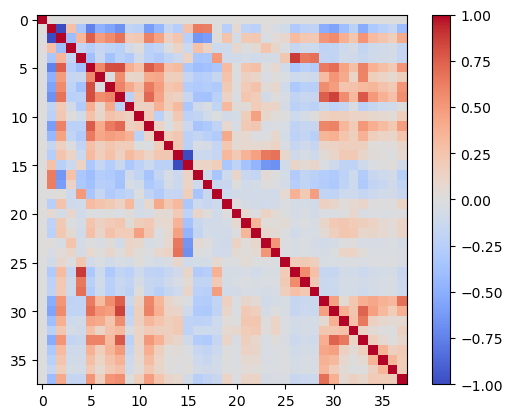

In [73]:
im = plt.imshow(classes.corr(),cmap='coolwarm')
plt.colorbar(im)

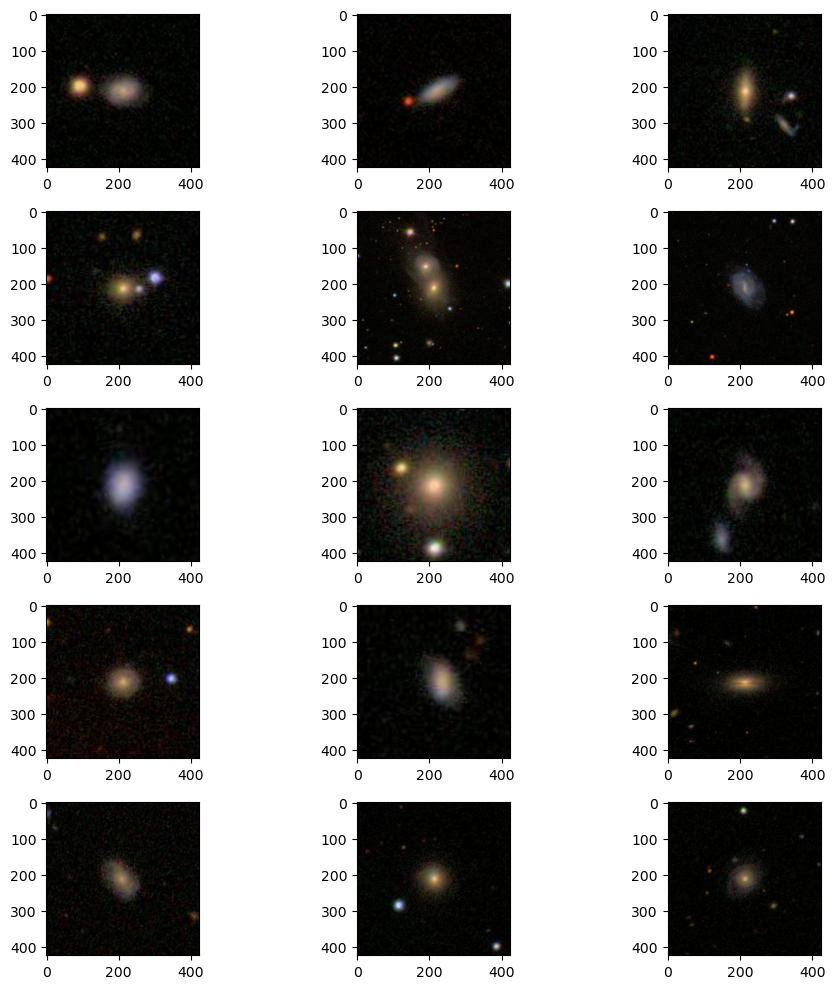

In [80]:
fig = plt.figure(figsize=(10,10))
fnames = filenames[hdb.labels_==3]
for i in range(15):
    ax = fig.add_subplot(5,3,i+1)
    ax.imshow(plt.imread(os.path.join(dirs['source_images'],fnames[i])))
plt.tight_layout()

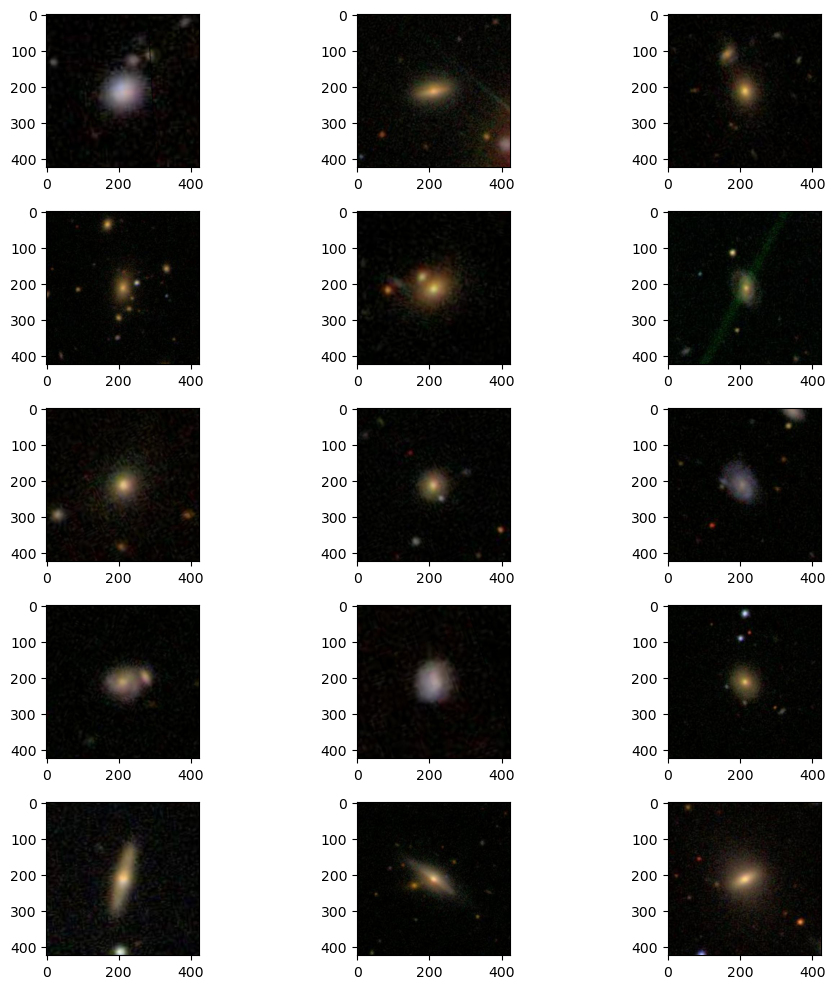

In [81]:
fig = plt.figure(figsize=(10,10))
fnames = filenames[hdb.labels_!=3]
for i in range(15):
    ax = fig.add_subplot(5,3,i+1)
    ax.imshow(plt.imread(os.path.join(dirs['source_images'],fnames[i])))
plt.tight_layout()

## Cropped images

In [117]:
X_embedded = skl.manifold.TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(features)

In [118]:
X_embedded.shape

(560, 2)

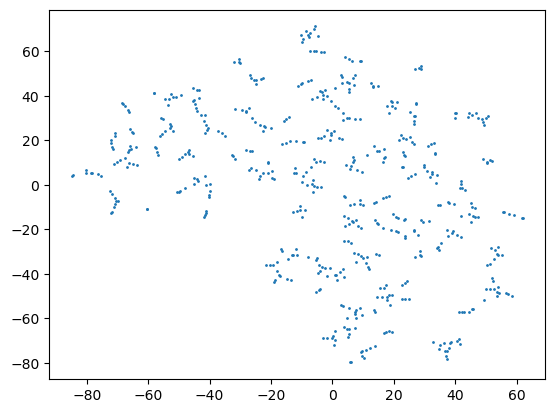

In [119]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=1)

In [120]:
hdb = skl.cluster.HDBSCAN(min_cluster_size=3)
hdb.fit(features)

HDBSCAN(min_cluster_size=3)

In [121]:
hdb.labels_

array([-1,  2,  2,  2,  2, -1,  2, -1,  2, -1,  2, -1,  2,  2,  2,  2,  2,
        2,  2, -1,  2,  1,  2, -1,  2,  2,  2,  2, -1,  2,  2,  2, -1,  2,
        2, -1,  2,  2,  2,  2,  2,  2,  2, -1,  2,  2, -1,  2,  2,  2,  2,
        2,  2, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2, -1,  2, -1, -1,  2,  2,  2,  2, -1, -1,  2,  2,  2,  2, -1,  2,
       -1,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1,  2,  2,  2,  2,  2,  2,
       -1,  2,  2, -1, -1,  2,  2,  2,  2, -1,  2,  2,  2, -1,  2,  0,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2, -1, -1, -1,  2,  2,  2,  2,  2,  2, -1,  2, -1,  2,
        2,  2,  2,  2,  3,  2, -1,  2,  2,  2, -1, -1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2, -1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2, -1,  2,  2,  2, -1,  2,  2,  2,  2, -1, -1,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, -1,
        2,  2, -1,  2,  2

In [ ]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

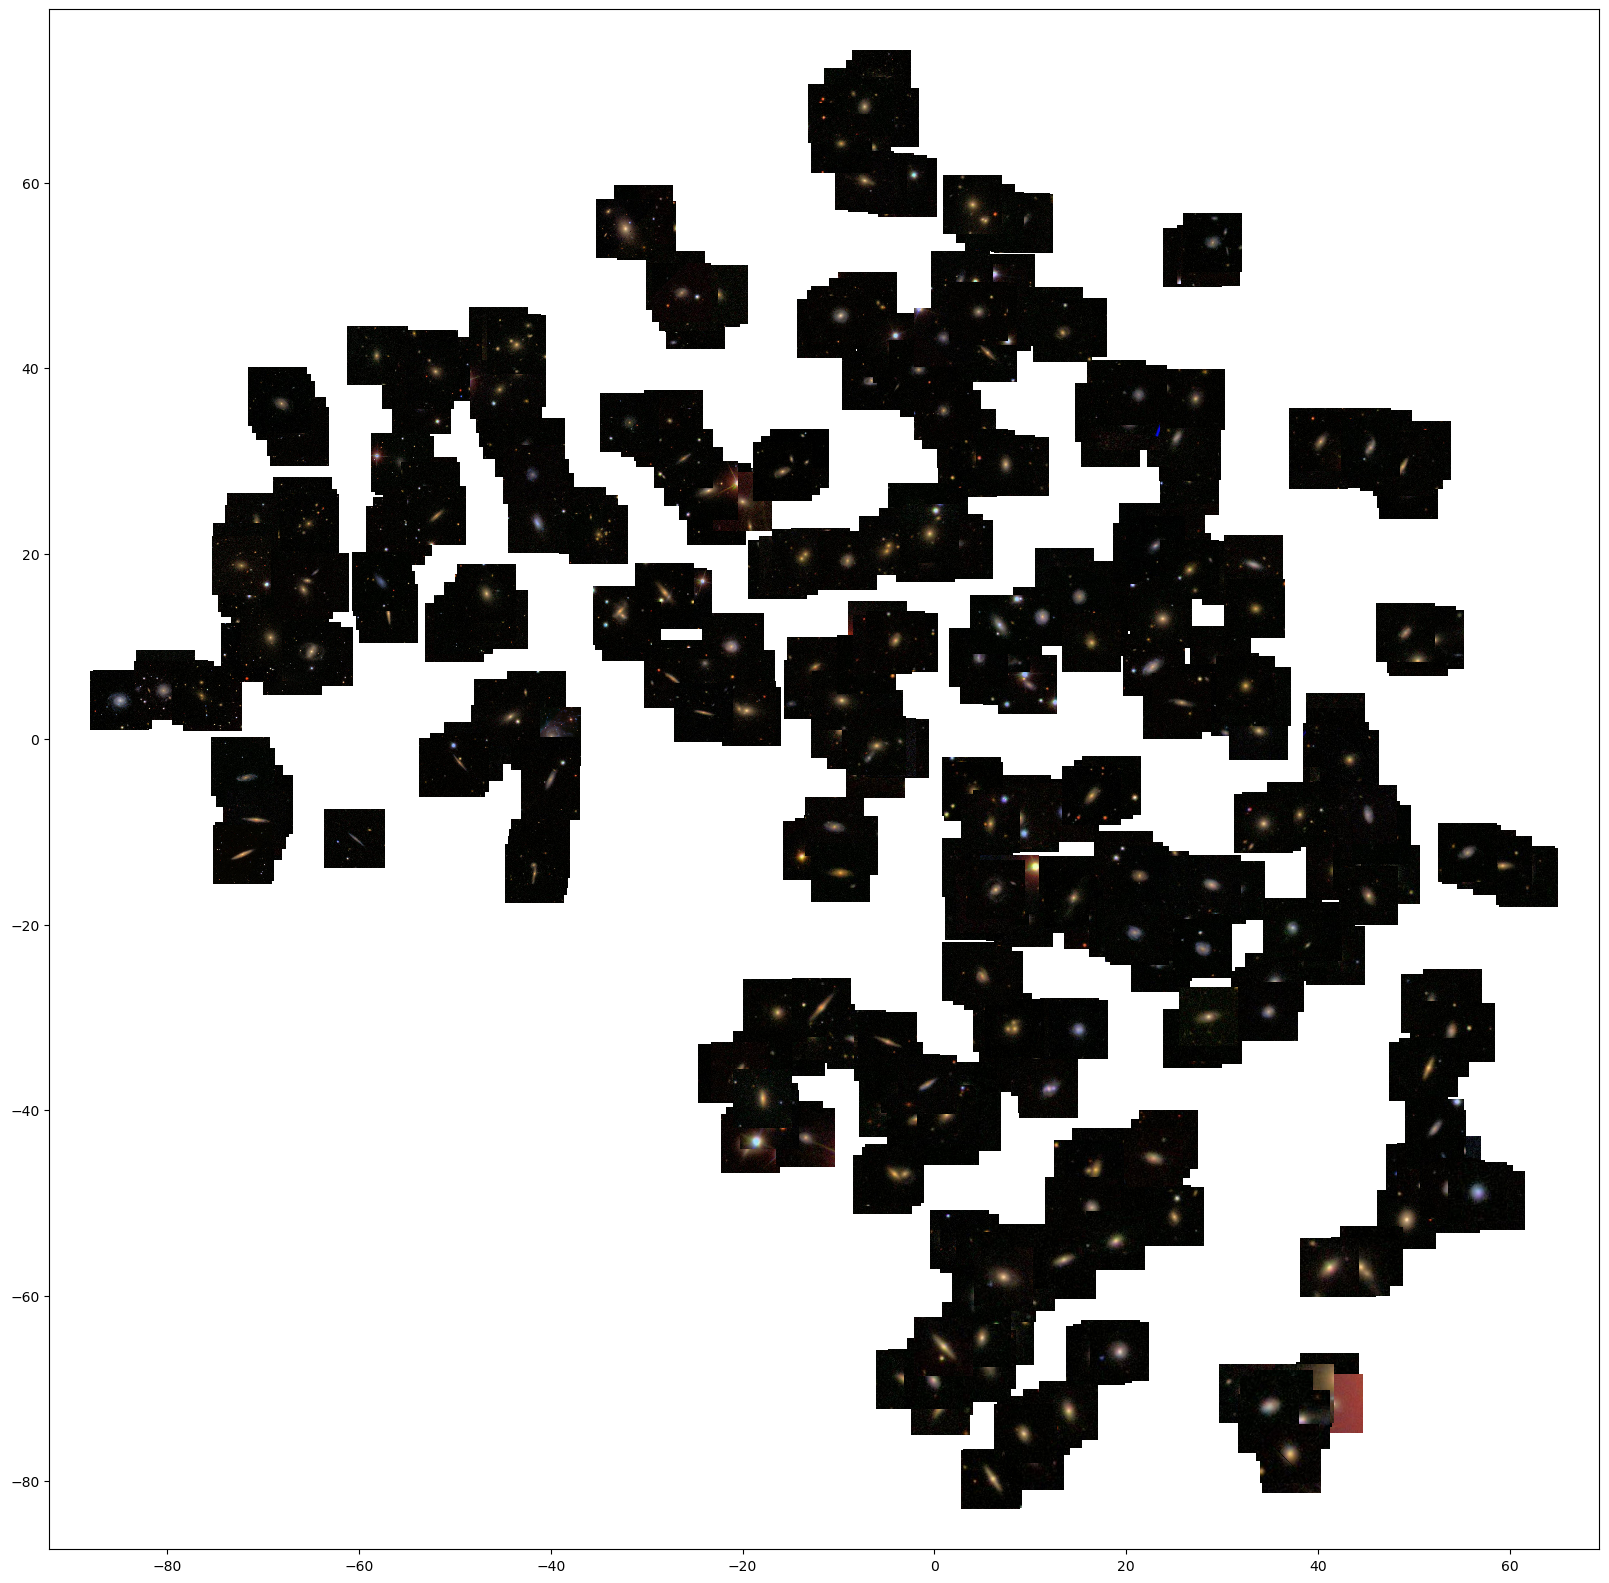

In [123]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def main():
    x = X_embedded[:,0]
    y = X_embedded[:,1]
    fig, ax = plt.subplots(figsize=(20,20))
    imscatter(x, y, filenames, zoom=0.1, ax=ax)
    #ax.plot(x, y)
    plt.show()

def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    artists = []
    for x0, y0, imgpath in zip(x, y,images):
        image = plt.imread(os.path.join(dirs['source_images'],imgpath))
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main()